In [1]:
from pandas_datareader.data import DataReader
import numpy as np
import plotly.graph_objs as go
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from stockstats import StockDataFrame
from sklearn.preprocessing import MinMaxScaler
from statistics import variance
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


def predict(num_prediction, model):
    prediction_list = test_X[-2:]

    for i in range(num_prediction):
        x = prediction_list[-1:]
        out = [float(model.predict(x)[-1:])]
        x = x.reshape(-1)
        for var in range(n_vars-1):
            out.append(x[var+1] + x[var+1] - prediction_list[-2,0,var+1])
        prediction_list = prediction_list.reshape(i+2,prediction_list.shape[2])
        prediction_list = np.vstack([prediction_list, out])
        prediction_list = prediction_list.reshape(i+3,1,prediction_list.shape[1])
    
    return prediction_list


def predict_dates(num_prediction):
    last_date = data.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction + 1).tolist()
    prediction_dates.pop(0)
    return prediction_dates



Input the ticker:aapl
                 Close
Date                  
2018-01-02   43.064999
2018-01-03   43.057499
2018-01-04   43.257500
2018-01-05   43.750000
2018-01-08   43.587502
...                ...
2022-06-13  131.880005
2022-06-14  132.759995
2022-06-15  135.429993
2022-06-16  130.059998
2022-06-17  131.559998

[1124 rows x 1 columns]


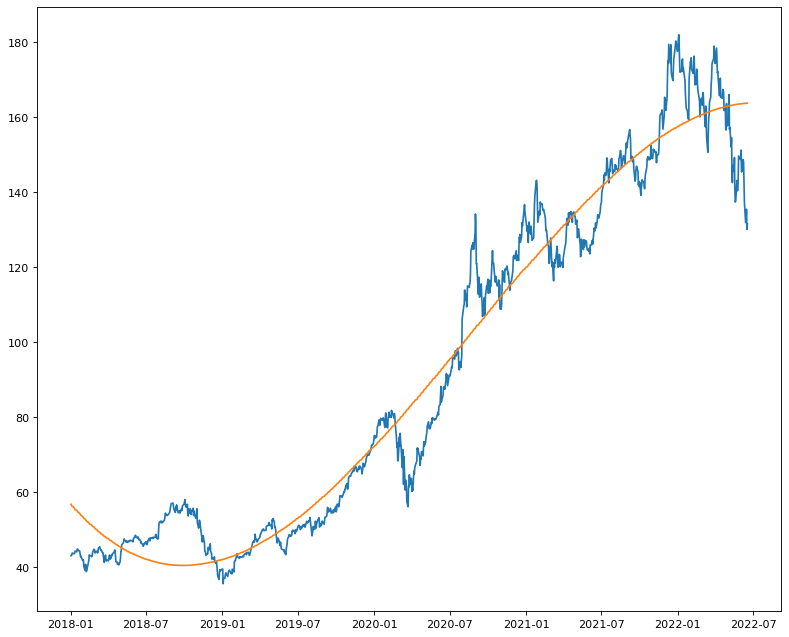

In [18]:
user_input = input('Input the ticker:')
# df = DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
df = DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now()- timedelta(days=7))
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
print(data)

# Convert the dataframe to a numpy array
dataset = data.values
date = data.index

date_number = np.linspace(1,len(date),len(date))
dataset = dataset.flatten()
mymodel = np.poly1d(np.polyfit(date_number, dataset, 3))
plt.figure(figsize=(12, 10), dpi=80)
plt.plot(date, dataset)
plt.plot(date, mymodel(date_number))
plt.show()

In [19]:
close_data_df = StockDataFrame.retype(df)
close_data_df.init_all()
# print(close_data_df.columns)

# print(stock)
# rsi = stock['rsi']
# kdj = stock['kdjj']
# macd = stock['macds']
# boll = stock['boll']
# ma = stock['close_10_ema']

# rsi = rsi[2:]
# kdj = kdj[2:]
# macd = macd[2:]
# boll = boll[2:]
# ma = ma[2:]

# close_data_df = pd.concat([data[2:],rsi,boll,ma,kdj,macd],axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled= scaler.fit_transform(close_data_df[['close']])

scaled_df = pd.DataFrame(scaled)
scaled_df.index = close_data_df.index
#scaled_df.columns = ['Close','rsi_6','boll','tema']
scaled_df.columns = ['close']

close_data_df = close_data_df.filter(['macds','macd'])
close_data_df = pd.concat([scaled_df,close_data_df],axis=1)
# close_data_df = scaled_df

print(close_data_df.corr())
close_data_df.head()

          close     macds      macd
close  1.000000  0.181486  0.160312
macds  0.181486  1.000000  0.952314
macd   0.160312  0.952314  1.000000


,close,macds,macd
Date,,,
2018-01-02,0.051327,0.000000,0.000000
2018-01-03,0.051276,-0.000093,-0.000168
2018-01-04,0.052641,0.002399,0.005988
2018-01-05,0.056004,0.010537,0.026422
2018-01-08,0.054895,0.016476,0.030504


In [20]:
mae_list = []
forecast_list = []
num_trials = 11
n_in=1
n_out=1
split_percent = 0.8
num_prediction = 10
dropnan = True
num_epochs = 25
batch_size = 16
run = True
fold = 5


n_vars = 1 if type(data) is list else close_data_df.shape[1]
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(close_data_df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, n_out):
    cols.append(close_data_df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
supervised_df = pd.concat(cols, axis=1)
supervised_df.columns = names
# drop rows with NaN values
if dropnan:
    supervised_df.dropna(inplace=True)
supervised_df = supervised_df.drop(supervised_df.columns[-n_vars+1:], axis=1)
# return agg

#series_to_supervised(close_data_df)
supervised_df.head()

supervised_data = supervised_df.to_numpy()

# split = int(split_percent * len(close_data_df))

# supervised_train = supervised_data[:split]
# supervised_test = supervised_data[split:]

# train_X, train_y = supervised_train[:, :-1], supervised_train[:, -1]
# test_X, test_y = supervised_test[:, :-1], supervised_test[:, -1]
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

close_data = close_data_df.to_numpy()
remainder = close_data.shape[0]%5
close_data = close_data[remainder:]
close_data_df = close_data_df.drop(close_data_df.index[range(0,remainder)])
print(close_data_df)

# date_train = date[:split]
# date_test = date[split+1:]

kfold=KFold(fold,True,7)
# print(kfold.split(supervised_train,supervised_test))

               close     macds      macd
Date                                    
2018-01-08  0.054895  0.016476  0.030504
2018-01-09  0.054860  0.020730  0.032170
2018-01-10  0.054792  0.023641  0.032231
2018-01-11  0.056482  0.028419  0.043525
2018-01-12  0.059572  0.038749  0.073134
...              ...       ...       ...
2022-06-13  0.657728 -3.288622 -3.779681
2022-06-14  0.663736 -3.493695 -4.313987
2022-06-15  0.681966 -3.689046 -4.470449
2022-06-16  0.645302 -3.945329 -4.970464
2022-06-17  0.655543 -4.193446 -5.185911

[1120 rows x 3 columns]


/Users/frankie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass shuffle=True, random_state=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



In [21]:
# for train, test in kfold.split(supervised_train,supervised_test):
#     print(train,test)
# print(supervised_data)
from sklearn.model_selection import train_test_split
X = supervised_data[:,0:3]
y = supervised_data[:,3:]
# print(X,y)
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0,shuffle=False)
# train_X = train_X.reshape(-1, 1, train_X.shape[1])
# test_X  = test_X.reshape(-1, 1, test_X.shape[1])
# train_y = train_y.reshape(-1, 1, train_y.shape[1])
# test_y = test_y.reshape(-1, 1, test_y.shape[1])
# print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
# print(train_X, test_X, train_y, test_y)
# yhat = model.predict(test_X)
print(X)

[[ 5.13271201e-02  0.00000000e+00  0.00000000e+00]
 [ 5.12759145e-02 -9.34791021e-05 -1.68262384e-04]
 [ 5.26414571e-02  2.39877136e-03  5.98761202e-03]
 ...
 [ 6.63736437e-01 -3.49369521e+00 -4.31398685e+00]
 [ 6.81966348e-01 -3.68904595e+00 -4.47044892e+00]
 [ 6.45301704e-01 -3.94532947e+00 -4.97046355e+00]]


In [22]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# X, y = np.arange(10).reshape((5, 2)), range(5,10)
# y=list(y)
# y=np.array(y)
# print(X,y)
# for train, test in kfold.split(X,y):
#     print('\n')
#     print(train,test)
# #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)
# #     print(X_train, X_test, y_train, y_test)

#     X_train, X_test = X[train],X[test]
#     print(X_train, X_test)
#     y_train, y_test = y[train],y[test]
#     print(y_train, y_test)

In [23]:
# print(close_data_df.index[train])

In [26]:
# while run == True:
#     for _ in range(num_trials):

run = True
num_trials = 3
mae_list = []
forecast_list = []
num_repeat = 1


while run == True:
    for _ in range(num_trials):
        i = 1
        for train, test in kfold.split(X,y):
            if i < 4:
                print(i)
                i += 1

        #             train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 1/5, random_state = 0,shuffle=False)
                train_X, test_X = X[train],X[test]
        #             print(X_train, X_test)
                train_y, test_y = y[train],y[test]
                date_train, date_test = date[train], date[test]
        #             print(y_train, y_test)        
                train_X = train_X.reshape(-1, 1, train_X.shape[1])
                test_X  = test_X.reshape(-1, 1, test_X.shape[1])
                train_y = train_y.reshape(-1, 1, train_y.shape[1])
                test_y = test_y.reshape(-1, 1, test_y.shape[1])


                model = Sequential()

                model.add(
                    LSTM(50,
                        activation='relu'))
                        #return_sequences=True,)
        #         )
                model.add(Dropout(0.2))
                # model.add(LSTM(128, return_sequences=True, input_shape= (date_train.shape[0], 1)))
                # model.add(LSTM(64, return_sequences=False))
                # model.add(Dense(25))
                model.add(Dense(units=1))
                model.compile(optimizer='adam', loss='mse')

                history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_data=(test_X, test_y))

                # get train_y
                train_y = train_y.reshape(train_y.shape[0],1)
                train_y = np.hstack([train_y, np.zeros(train_y.shape)])
                train_y = scaler.inverse_transform(train_y)
                #     train = np.delete(train,[1,scaled_df.shape[1]],1)
                train_y = train_y[:,:1]
                train_y = train_y.reshape((-1))

                # get test_y
                test_y = test_y.reshape((test_X.shape[0], test_X.shape[1]))
                inv_testy = np.hstack([test_y,np.zeros(test_y.shape)])
                inv_testy = scaler.inverse_transform(inv_testy)
                inv_testy = inv_testy[:,:1]
                test_y = inv_testy.reshape((-1))
#                 train = train_y.reshape(train_y.shape[0],1)
#                 train = np.hstack([train, np.zeros(train.shape)])
#                 train = scaler.inverse_transform(train)
#                 #     train = np.delete(train,[1,scaled_df.shape[1]],1)
#                 train = train[:,:1]
#                 train = train.reshape((-1))
#                 test = inv_testy.reshape((-1))
                # print('\nHead of "inv_testy":\n',inv_testy[:5])
                
                # Validate with test_X
                yhat = model.predict(test_X)
                yhat_df = pd.DataFrame(yhat)
                yhat_df.index = close_data_df.index[test-3]
                yhat_df.columns = ['Close']
                # print(yhat_df)
                new_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
                inv_yhat = np.concatenate((yhat_df, new_test_X[:,1:scaled_df.shape[1]]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                prediction = inv_yhat[:,:1]
                prediction = prediction.reshape((-1))
                # print('\nHead of "inv_yhat":\n',inv_yhat[:5])

#                 test_y = test_y.reshape((test_X.shape[0], test_X.shape[1]))
#                 inv_testy = np.hstack([test_y,np.zeros(test_y.shape)])
#                 inv_testy = scaler.inverse_transform(inv_testy)
#                 inv_testy = inv_testy[:,:1]
                # print('\nHead of "inv_testy":\n',inv_testy[:5])

                
                

                forecast = (predict(num_prediction, model))
                forecast = forecast.reshape(num_prediction + 2,forecast.shape[2])
            #     forecast = np.delete(forecast,slice(-(close_data_df.shape[1] - scaled_df.shape[1]),forecast.shape[1]),1)
                forecast = np.delete(forecast,slice(scaled_df.shape[1],forecast.shape[1]),1)
                #print(close_data_df.shape[1] - scaled_df.shape[1])
                forecast = scaler.inverse_transform(forecast)
                forecast = np.delete(forecast,slice(1,forecast.shape[1]),1)
                forecast = forecast.reshape((-1))
                forecast_list = np.append(forecast_list,np.array([forecast]))

                score = mean_absolute_error(test_y, prediction)
                mae_list.append(score)
                print(mae_list)

    forecast_list = np.reshape(forecast_list,[3*num_repeat*num_trials,num_prediction + 2])
    forecast_5days = forecast_list[:,2:7]

    var_list = []
    for i in range(forecast_5days.shape[0]):
        var = variance(forecast_5days[i])
        var_list.append(var)    
    #     print(min(var_list))
    if min(var_list) > 10:
        run = True
        print('Retraining')
        num_repeat += 1
    else:
        run = False
        print(
            '\nMinimum of mae: ',min(mae_list),
            '\nAverage of mae: ',(sum(mae_list) - max(mae_list))/(len(mae_list) - 1),
            '\nMaximum of mae: ',max(mae_list)
        )

        
            
        var = np.var(forecast_5days,axis = 1)
        maxindex = np.argmax(var)
    #     forecast_5days = np.delete(forecast_5days,maxindex,0)
        print(forecast_5days)

        small_var_prediction = forecast_5days[var_list.index(min(var_list))]
        print('\nPrediction with smallest variance: ',small_var_prediction)
        print('mae: ',mae_list[var_list.index(min(var_list))])
        forecast_dates = predict_dates(num_prediction)
        trace1 = go.Scatter(
            x=date_train,
            y=train_y,
            mode='lines',
            name='Data'
        )
        trace2 = go.Scatter(
            x=date_test,
            y=prediction,
            mode='lines',
            name='Prediction'
        )
        trace3 = go.Scatter(
            x=date_test,
            y=test_y,
            mode='lines',
            name='Ground Truth'
        )
        layout = go.Layout(
            title="Stock",
            xaxis={'title': "Date"},
            yaxis={'title': "Close"}
        )
        trace4 = go.Scatter(
            x=forecast_dates,
            y=small_var_prediction,
            mode='lines',
            name='Future Prediction'
        )
        fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
        fig.show()

        small_mae_prediction = forecast_5days[mae_list.index(min(mae_list))]
        print('\nPrediction with best mae: ',small_mae_prediction)
        print('mae: ',min(mae_list))

        trace4 = go.Scatter(
            x=forecast_dates,
            y=small_mae_prediction,
            mode='lines',
            name='Future Prediction'
        )
        fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
        fig.show()

1
Epoch 1/25
57/57 [==============================] - 1s 5ms/step - loss: 0.1411 - val_loss: 0.0698
Epoch 2/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0715 - val_loss: 0.0524
Epoch 3/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0394
Epoch 4/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0284
Epoch 5/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0277 - val_loss: 0.0182
Epoch 6/25
57/57 [==============================] - 0s 5ms/step - loss: 0.0200 - val_loss: 0.0103
Epoch 7/25
57/57 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0047
Epoch 8/25
57/57 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 9/25
57/57 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 10/25
57/57 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 11/25
57/57

Epoch 6/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0073
Epoch 7/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0032
Epoch 8/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 9/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 10/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 7.1484e-04
Epoch 11/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 4.6470e-04
Epoch 12/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 4.0461e-04
Epoch 13/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 14/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 7.5357e-04
Epoch 15/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 3.935

57/57 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 9.6971e-04
Epoch 10/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 8.4457e-04
Epoch 11/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 4.8971e-04
Epoch 12/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 5.0860e-04
Epoch 13/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 3.7442e-04
Epoch 14/25
57/57 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 4.9207e-04
Epoch 15/25
57/57 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 4.5587e-04
Epoch 16/25
57/57 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 4.1236e-04
Epoch 17/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 3.9041e-04
Epoch 18/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0038 - val


Prediction with best mae:  [139.67470759 137.18264241 136.22039525 136.9678533  138.10453149]
mae:  1.8257734091468032


In [ ]:
# train_y, test_y = y[train],y[test]
# train = train_y.reshape(train_y.shape[0],1)
# train = np.hstack([train, np.zeros(train.shape)])
# train = scaler.inverse_transform(train)
# #     train = np.delete(train,[1,scaled_df.shape[1]],1)
# train = train[:,:1]
# train = train.reshape((-1))
# print(test_y)

In [ ]:
# print(var_list)

train = train_y.reshape(train_y.shape[0],1)
train = np.hstack([train, np.zeros(train.shape)])
train = scaler.inverse_transform(train)
#     train = np.delete(train,[1,scaled_df.shape[1]],1)
train = train[:,:1]
train = train.reshape((-1))


test_y = test_y.reshape((test_X.shape[0], test_X.shape[1]))
inv_testy = np.hstack([test_y,np.zeros(test_y.shape)])
inv_testy = scaler.inverse_transform(inv_testy)
inv_testy = inv_testy[:,:1]
test = inv_testy.reshape((-1))
# print(test)

small_var_prediction = forecast_5days[var_list.index(min(var_list))]

trace1 = go.Scatter(
    x=date_train,
    y=train,
    mode='lines',
    name='Data'
)
trace2 = go.Scatter(
    x=date_test,
    y=prediction,
    mode='lines',
    name='Prediction'
)
trace3 = go.Scatter(
    x=date_test,
    y=test,
    mode='lines',
    name='Ground Truth'
)
layout = go.Layout(
    title="Stock",
    xaxis={'title': "Date"},
    yaxis={'title': "Close"}
)
trace4 = go.Scatter(
    x=forecast_dates,
    y=small_var_prediction,
    mode='lines',
    name='Future Prediction'
)
print('mae: ',mae_list[var_list.index(min(var_list))])
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

print('mae: ',min(mae_list))
trace4 = go.Scatter(
    x=forecast_dates,
    y=small_mae_prediction,
    mode='lines',
    name='Future Prediction'
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

In [27]:
# score for forecast
actual_df =  DataReader(user_input, data_source='yahoo', start='2018-01-01', end=datetime.now())
actual_price = actual_df.filter(['Close'])
actual = actual_price[-5:]
print(actual)

# seleted_forecast = forecast_5days[3]
# seleted_forecast = seleted_forecast.reshape(5,1)
# seleted_forecast = [143.69,144.59,146.14,148.19,150.65]
# seleted_forecast = [148.95,148.17,147.25,146.42,146.37]
print('\nForecast 5 days:\n',small_var_prediction)
forecast_score = mean_absolute_error(small_var_prediction,actual)
print('mae: ',forecast_score)
print('\nForecast 5 days:\n',small_mae_prediction)
forecast_score = mean_absolute_error(small_mae_prediction,actual)
print('mae: ',forecast_score)

                 Close
Date                  
2022-06-17  131.559998
2022-06-21  135.869995
2022-06-22  135.350006
2022-06-23  138.270004
2022-06-24  141.660004

Forecast 5 days:
 [139.67470759 137.18264241 136.22039525 136.9678533  138.10453149]
mae:  3.031073921514326

Forecast 5 days:
 [139.67470759 137.18264241 136.22039525 136.9678533  138.10453149]
mae:  3.031073921514326


In [ ]:
# print(date_test.shape,date_train.shape)
# print(date.shape)
# print(train_y.shape,test_y.shape)
# print(supervised_test.shape)

In [ ]:
# small_mae_prediction = forecast_5days[mae_list.index(min(mae_list))]
# print('\nPrediction with best mae: ',small_mae_prediction)
# trace1 = go.Scatter(
#     x=date_train,
#     y=train,
#     mode='lines',
#     name='Data'
# )
# trace2 = go.Scatter(
#     x=date_test,
#     y=prediction,
#     mode='lines',
#     name='Prediction'
# )
# trace3 = go.Scatter(
#     x=date_test,
#     y=test,
#     mode='lines',
#     name='Ground Truth'
# )
# layout = go.Layout(
#     title="Stock",
#     xaxis={'title': "Date"},
#     yaxis={'title': "Close"}
# )
# trace4 = go.Scatter(
#     x=forecast_dates,
#     y=small_mae_prediction,
#     mode='lines',
#     name='Future Prediction'
# )
# fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
# fig.show()

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.title('Model loss')
# plt.show()

In [ ]:
# arraya = np.array([[1,2,3,40,5,6,7],[2,3,4,5,6,7,8],[3,4,5,6,7,8,9]])
# var = np.var(arraya,axis=1)
# maxindex = np.argmax(var)
# new_arraya = np.delete(arraya,maxindex,0)
# print(new_arraya)